# Load data using dataframe.

In [28]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


import os

In [29]:
# Load data in file Data/Session_3.csv into a pandas dataframe  


# Load data from file
data = pd.read_csv(os.path.join('Data','Session_3.csv'))

# fill column 'EDA' with random values with the same length as the data
data['EDA'] = np.random.rand(len(data))


# Display the data
print(data)




         Time  Resp  ECG       EDA Trigger
0       0.000   0.0  0.0  0.480943    -1.0
1       0.001   0.0  0.0  0.175132    -1.0
2       0.002   0.0  0.0  0.258083    -1.0
3       0.003   0.0  0.0  0.955277    -1.0
4       0.004   1.0  0.0  0.258677    -1.0
...       ...   ...  ...       ...     ...
35995  35.995   0.0  0.0  0.382849    -1.0
35996  35.996   0.0  0.0  0.441748    -1.0
35997  35.997   0.0  0.0  0.395589    -1.0
35998  35.998   0.0  0.0  0.212568    -1.0
35999  35.999   0.0  0.0  0.001841    -1.0

[36000 rows x 5 columns]


In [32]:
# set trigger to 1 for each 10 seconds
data['Trigger'] = 0
data.loc[data.index % 3600 == 0, 'Trigger'] = 1

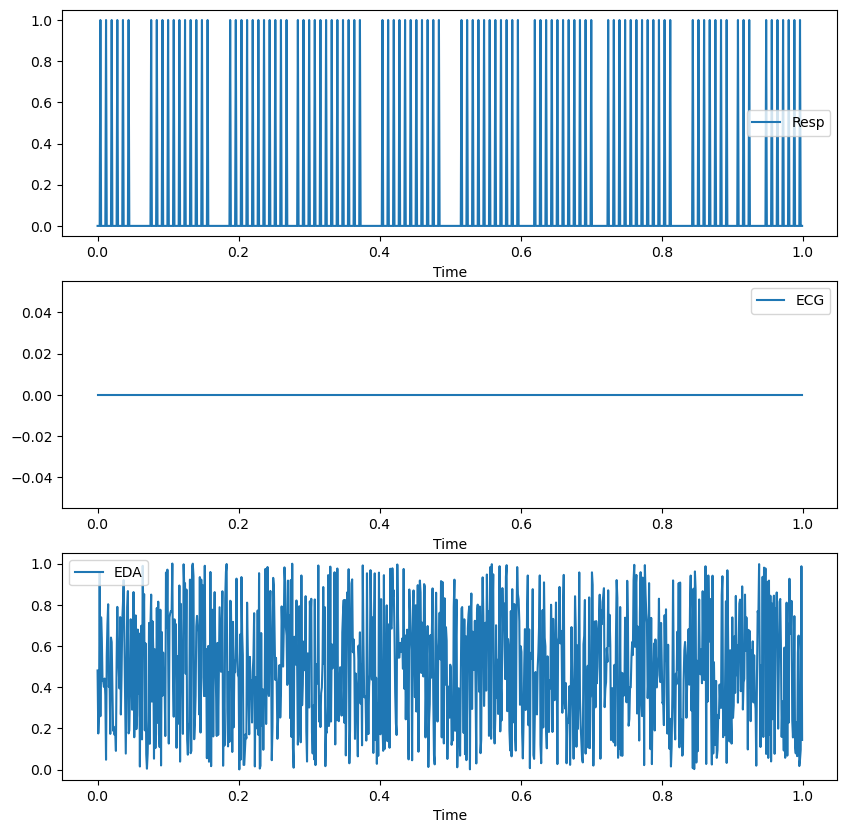

In [33]:
# plot the data, x-axis is the first column, subplots for the second, third and fourth column

# figure with 3 subplots only show 10 seconds of data
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# plot the data
data.iloc[:1000].plot(x='Time', y='Resp', ax=axs[0])
data.iloc[:1000].plot(x='Time', y='ECG', ax=axs[1])
data.iloc[:1000].plot(x='Time', y='EDA', ax=axs[2])

# show the plot
plt.show()



In [38]:
# segment data using column trigger
# find the indices where the trigger is 1
triggers = data['Trigger'] == 1
indices = np.where(triggers)[0]

print(indices)
segmentSize=100

# segment the data
segments = []
for i in range(len(indices) - 1):
    segments.append(data.iloc[indices[i]:indices[i]+segmentSize])


[    0  3600  7200 10800 14400 18000 21600 25200 28800 32400]


In [40]:
# compute average of segments
averages = []
for segment in segments:
    averages.append(segment.mean())

    

In [41]:
averages

[Time       0.049500
 Resp       0.090000
 ECG        0.000000
 EDA        0.462899
 Trigger    0.010000
 dtype: float64,
 Time       3.649500
 Resp       0.090000
 ECG        0.000000
 EDA        0.526706
 Trigger    0.010000
 dtype: float64,
 Time       7.249500
 Resp       0.110000
 ECG        0.000000
 EDA        0.502031
 Trigger    0.010000
 dtype: float64,
 Time       10.849500
 Resp        0.090000
 ECG         0.000000
 EDA         0.470519
 Trigger     0.010000
 dtype: float64,
 Time       14.449500
 Resp        0.100000
 ECG         0.000000
 EDA         0.480637
 Trigger     0.010000
 dtype: float64,
 Time       18.049500
 Resp        0.090000
 ECG         0.000000
 EDA         0.531229
 Trigger     0.010000
 dtype: float64,
 Time       21.64950
 Resp        0.10000
 ECG         0.00000
 EDA         0.50649
 Trigger     0.01000
 dtype: float64,
 Time       25.249500
 Resp        0.100000
 ECG         0.000000
 EDA         0.466023
 Trigger     0.010000
 dtype: float64,
 Tim